In [2]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

# **Image Captioning**

**What is Image Captioning ?**
- Image Captioning is the process of generating textual description of an image. It uses both Natural Language Processing and Computer Vision to generate the captions.
- This task lies at the intersection of computer vision and natural language processing. Most image captioning systems use an encoder-decoder framework, where an input image is encoded into an intermediate representation of the information in the image, and then decoded into a descriptive text sequence.

**CNNs + RNNs (LSTMs)**
- To perform Image Captioning we will require two deep learning models combined into one for the training purpose
- CNNs extract the features from the image of some vector size aka the vector embeddings. The size of these embeddings depend on the type of pretrained network being used for the feature extraction
- LSTMs are used for the text generation process. The image embeddings are concatenated with the word embeddings and passed to the LSTM to generate the next word
- For a more illustrative explanation of this architecture check the Modelling section for a picture representation

<img src="https://miro.medium.com/max/1400/1*6BFOIdSHlk24Z3DFEakvnQ.png">

In [3]:
image_path = '../input/flickr8k/Images'

In [4]:
image_test = '../input/imagetest'
print(image_test)

../input/imagetest


In [5]:
data = pd.read_csv("../input/flickr8k/captions.txt")
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [6]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"../input/flickr8k/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

# **Visualization**
- Images and their corresponding captions

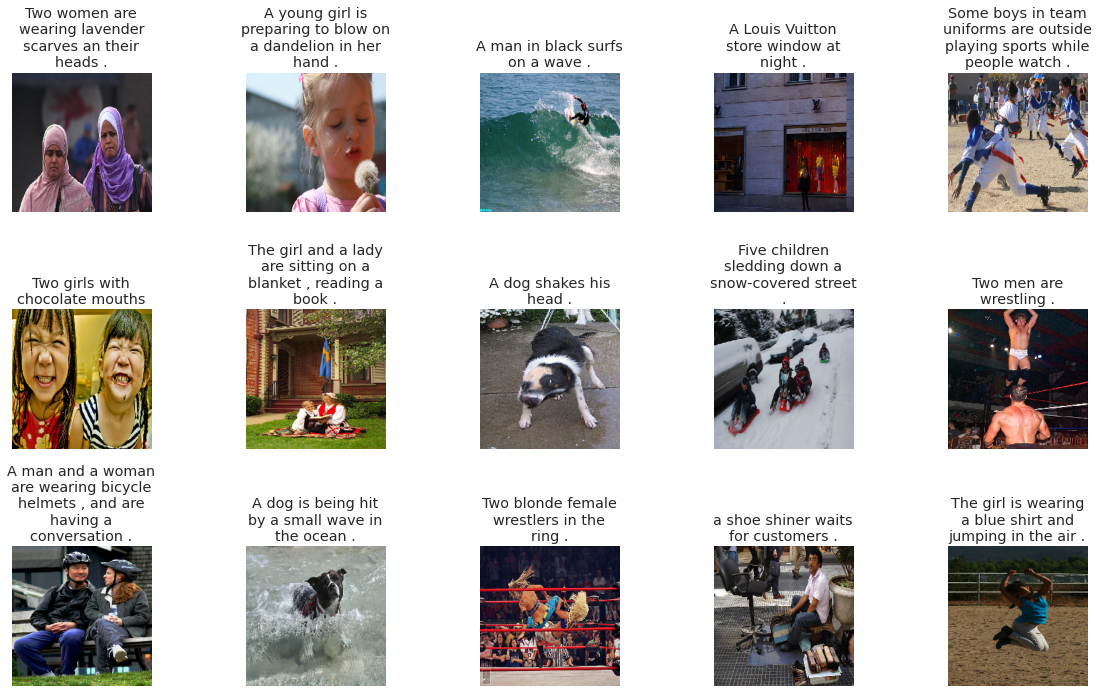

In [7]:
display_images(data.sample(15))

# **Caption Text Preprocessing Steps**
- Convert sentences into lowercase
- Remove special characters and numbers present in the text
- Remove extra spaces
- Remove single characters
- Add a starting and an ending tag to the sentences to indicate the beginning and the ending of a sentence

<img src='http://zjpnrm2br14wspo448nls17u-wpengine.netdna-ssl.com/wp-content/uploads/2020/09/processing-steps.png' >

In [8]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data

## __Preprocessed Text__

In [9]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

## __Tokenization and Encoded Representation__
- The words in a sentence are separated/tokenized and encoded in a one hot representation
- These encodings are then passed to the embeddings layer to generate word embeddings

<img src='https://lena-voita.github.io/resources/lectures/word_emb/lookup_table.gif'>

In [10]:
#test
# max_length = 1000

In [11]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 18, 315, 63, 195, 116, 2]

# **Image Feature Extraction**
- DenseNet 201 Architecture is used to extract the features from the images
- Any other pretrained architecture can also be used for extracting features from these images
- Since the Global Average Pooling layer is selected as the final layer of the DenseNet201 model for our feature extraction, our image embeddings will be a vector of size 1920

<img src="https://imgur.com/wWHWbQt.jpg">

In [12]:
# test ------->>> Actual code in the last move there
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
#for image in tqdm(data['image'].unique().tolist()):
img = load_img(os.path.join(image_test,'1548703839.jpg'),target_size=(img_size,img_size))
img = img_to_array(img)
img = img/255.
img = np.expand_dims(img,axis=0)
feature = fe.predict(img, verbose=0)
features['1548703839.jpg'] = feature
print(features)

82534400/82524592 [==============================] - 1s 0us/step
{'1548703839.jpg': array([[4.48484498e-05, 8.71073746e-04, 1.70886272e-03, ...,
        5.70549846e-01, 1.01272844e-01, 0.00000000e+00]], dtype=float32)}


In [13]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

100%|██████████| 8091/8091 [12:57<00:00, 10.41it/s]


# **Data Generation**
- Since Image Caption model training like any other neural network training is a highly resource utillizing process we cannot load the data into the main memory all at once, and hence we need to generate the data in the required format batch wise
- The inputs will be the image embeddings and their corresonding caption text embeddings for the training process
- The text embeddings are passed word by word for the caption generation during inference time

In [14]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y

# **Modelling**
- The image embedding representations are concatenated with the first word of sentence ie. starseq and passed to the LSTM network 
- The LSTM network starts generating words after each input thus forming a sentence at the end

<img src='https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png'>

In [15]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

In [16]:
from tensorflow.keras.utils import plot_model

## **Model Modification**
- A slight change has been made in the original model architecture to push the performance. The image feature embeddings are added to the output of the LSTMs and then passed on to the fully connected layers
- This slightly improves the performance of the model orignally proposed back in 2014: __Show and Tell: A Neural Image Caption Generator__ (https://arxiv.org/pdf/1411.4555.pdf)

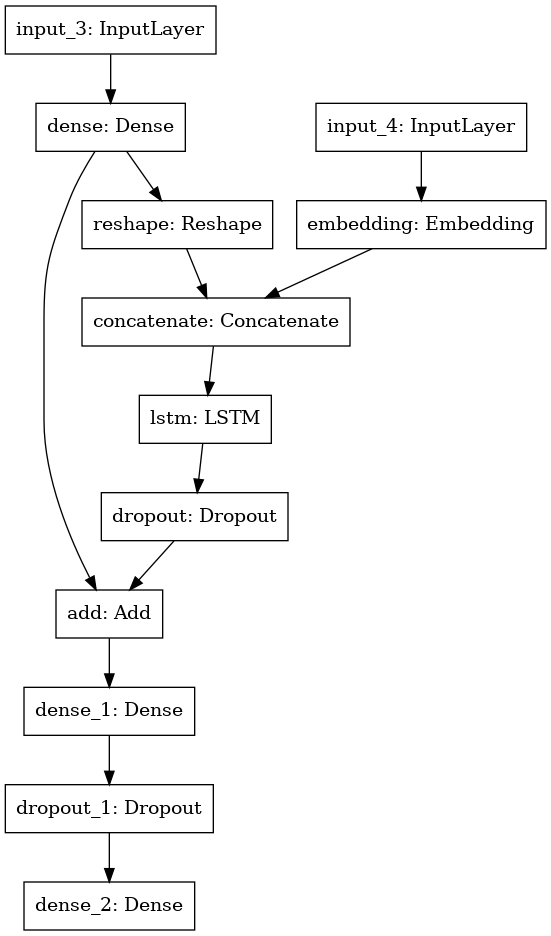

In [17]:
plot_model(caption_model)

In [18]:
caption_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1920)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          491776      input_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 1, 256)       0           dense[0][0]                      
____________________________________________________________________________________________

In [19]:
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [20]:
#test
# path_checkpoint = "training_1/cp.ckpt"
# directory_checkpoint = os.path.dirname(path_checkpoint)
# # callback = tf.keras.callbacks.ModelCheckpoint(filepath=path_checkpoint,
# #                                                  save_weights_only=True,
# #                                                  verbose=1)
# model_name = "model.h5"
# checkpoint = ModelCheckpoint(model_name,
#                          filepath=path_checkpoint,
#                         monitor="val_loss",
#                         mode="min",
#                         save_weights_only = True,
#                         verbose=1)

In [21]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)


earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

## **Let's train the Model !**

<img src='https://miro.medium.com/max/1400/1*xIXqf46yYonSXkUOWcOCvg.gif'>

In [22]:
history = caption_model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50
537/537 [==============================] - 250s 459ms/step - loss: 5.1522 - val_loss: 4.2700

Epoch 00001: val_loss improved from inf to 4.27002, saving model to model.h5
Epoch 2/50
537/537 [==============================] - 51s 95ms/step - loss: 4.2017 - val_loss: 3.9344

Epoch 00002: val_loss improved from 4.27002 to 3.93438, saving model to model.h5
Epoch 3/50
537/537 [==============================] - 50s 94ms/step - loss: 3.9318 - val_loss: 3.7838

Epoch 00003: val_loss improved from 3.93438 to 3.78382, saving model to model.h5
Epoch 4/50
537/537 [==============================] - 52s 97ms/step - loss: 3.7649 - val_loss: 3.7109

Epoch 00004: val_loss improved from 3.78382 to 3.71085, saving model to model.h5
Epoch 5/50
537/537 [==============================] - 50s 93ms/step - loss: 3.6495 - val_loss: 3.6645

Epoch 00005: val_loss improved from 3.71085 to 3.66447, saving model to model.h5
Epoch 6/50
537/537 [==============================] - 50s 93ms/step - loss: 3.5544

# **Inference**
- Learning Curve (Loss Curve)
- Assessment of Generated Captions (by checking the relevance of the caption with respect to the image, BLEU Score will not be used in this kernel)

## **Learning Curve**
- The model has clearly overfit, possibly due to less amount of data
- We can tackle this problem in two ways
    1. Train the model on a larger dataset Flickr40k
    2. Attention Models

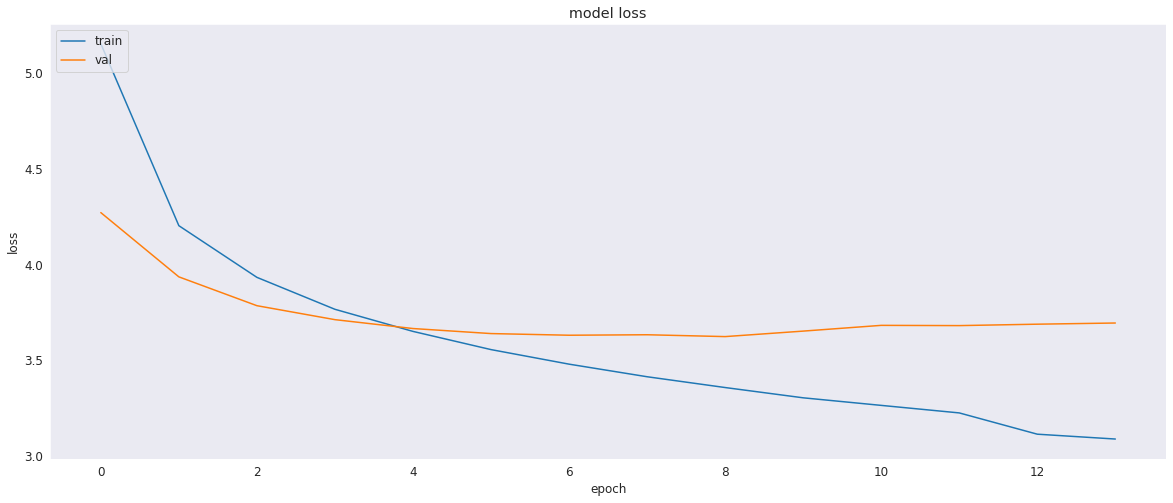

In [23]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## **Caption Generation Utility Functions**
- Utility functions to generate the captions of input images at the inference time.
- Here the image embeddings are passed along with the first word, followed by which the text embedding of each new word is passed to generate the next word

In [24]:
def idx_to_word(integer,tokenizer):
    
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [25]:
def predict_caption(model, image, tokenizer, max_length, features):
    
    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text+= " " + word
        
        if word == 'endseq':
            break
            
    return in_text 

## **Taking 15 Random Samples for Caption Prediction**

In [26]:
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

In [27]:
print(type(samples))

<class 'pandas.core.frame.DataFrame'>


In [28]:
# for index,record in samples.iterrows():
#     print(image[path])
#     print (record['image'])

In [29]:
# test
# new_model = tensorflow.keras.models.load_model('../input/modelh5/model.h5')


In [30]:
for index,record in samples.iterrows():
    
    print(type(record['image']))
    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.
    
    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    samples.loc[index,'caption'] = caption

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


In [31]:
#test

all_images = os.listdir(image_test)

img_size = 224
features = {}

for i in all_images:
    img = load_img(os.path.join(image_test,i),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[i] = feature
    print(features)

{'1606431208933658624.jpg': array([[9.3589013e-05, 6.2139379e-04, 1.5413850e-03, ..., 2.0498745e-03,
        1.3782289e+00, 2.9844001e-01]], dtype=float32)}
{'1606431208933658624.jpg': array([[9.3589013e-05, 6.2139379e-04, 1.5413850e-03, ..., 2.0498745e-03,
        1.3782289e+00, 2.9844001e-01]], dtype=float32), '1270067126_170667a.jpg': array([[3.6001202e-05, 1.1184182e-03, 1.2224209e-03, ..., 2.6760602e+00,
        1.9187967e-01, 2.4033877e-01]], dtype=float32)}
{'1606431208933658624.jpg': array([[9.3589013e-05, 6.2139379e-04, 1.5413850e-03, ..., 2.0498745e-03,
        1.3782289e+00, 2.9844001e-01]], dtype=float32), '1270067126_170667a.jpg': array([[3.6001202e-05, 1.1184182e-03, 1.2224209e-03, ..., 2.6760602e+00,
        1.9187967e-01, 2.4033877e-01]], dtype=float32), '1606422684149370880.jpg': array([[9.2555354e-05, 8.1279670e-04, 1.3398187e-03, ..., 9.9080080e-01,
        3.1282613e-01, 7.6332474e-01]], dtype=float32)}
{'1606431208933658624.jpg': array([[9.3589013e-05, 6.2139379e-0

In [32]:
# test
# model = DenseNet201()
# fe = Model(inputs=model.input, outputs=model.layers[-2].output)

# img_size = 224
# features = {}
# for image in tqdm(data['image'].unique().tolist()):
#     img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
#     img = img_to_array(img)
#     img = img/255.
#     img = np.expand_dims(img,axis=0)
#     feature = fe.predict(img, verbose=0)
#     features[image] = feature

# img_size = 224
# features = {}
# #for image in tqdm(data['image'].unique().tolist()):
# img = load_img(os.path.join(image_test,'1606429504657920000.jpg'),target_size=(img_size,img_size))
# img = img_to_array(img)
# img = img/255.
# img = np.expand_dims(img,axis=0)
# feature = fe.predict(img, verbose=0)
# features['1606429504657920000.jpg'] = feature
# print(features)

In [33]:
#test
for i in all_images:
    img = load_img(os.path.join(image_test,i),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.
    caption = predict_caption(caption_model, i, tokenizer, max_length, features)
    #samples.loc[index,'caption'] = caption
    print(caption)

startseq man in black jacket is standing on mountain endseq
startseq man in sunglasses and sunglasses and sunglasses endseq
startseq man in blue shirt is holding his head endseq
startseq man in red shirt is holding up up the camera endseq
startseq two people are standing on the beach endseq
startseq woman in black shirt and black shirt and black shirt and black shirt endseq
startseq man in red shirt is standing on the grass endseq
startseq two people are standing on the beach endseq
startseq group of people are sitting on the floor endseq
startseq two girls are playing in the grass endseq
startseq group of people are standing in the grass endseq
startseq the car is driving through the car endseq
startseq woman in black shirt and glasses is sitting on the floor endseq
startseq man in black jacket is standing on the beach endseq
startseq man in black shirt and glasses is sitting on the floor endseq
startseq two men in red shirt are playing in the air endseq
startseq man in black shirt an

In [34]:
# test
# for index,record in samples.iterrows():
#     print(type('1548703839.jpg'))
#     print(features)
# img = load_img(os.path.join(image_test,'1606429504657920000.jpg'),target_size=(224,224))
# img = img_to_array(img)
# img = img/255.

# caption = predict_caption(caption_model, '1606429504657920000.jpg', tokenizer, max_length, features)
# #samples.loc[index,'caption'] = caption
# print(caption)

# **Results**
- As we can clearly see there is some redundant caption generation e.g. Dog running through the water, overusage of blue shirt for any other coloured cloth
- The model performance can be further improved by training on more data and using attention mechanism so that our model can focus on relevant areas during the text generation
- We can also leverage the interprettability of the attention mechanism to understand which areas of the image leads to the generation of which word

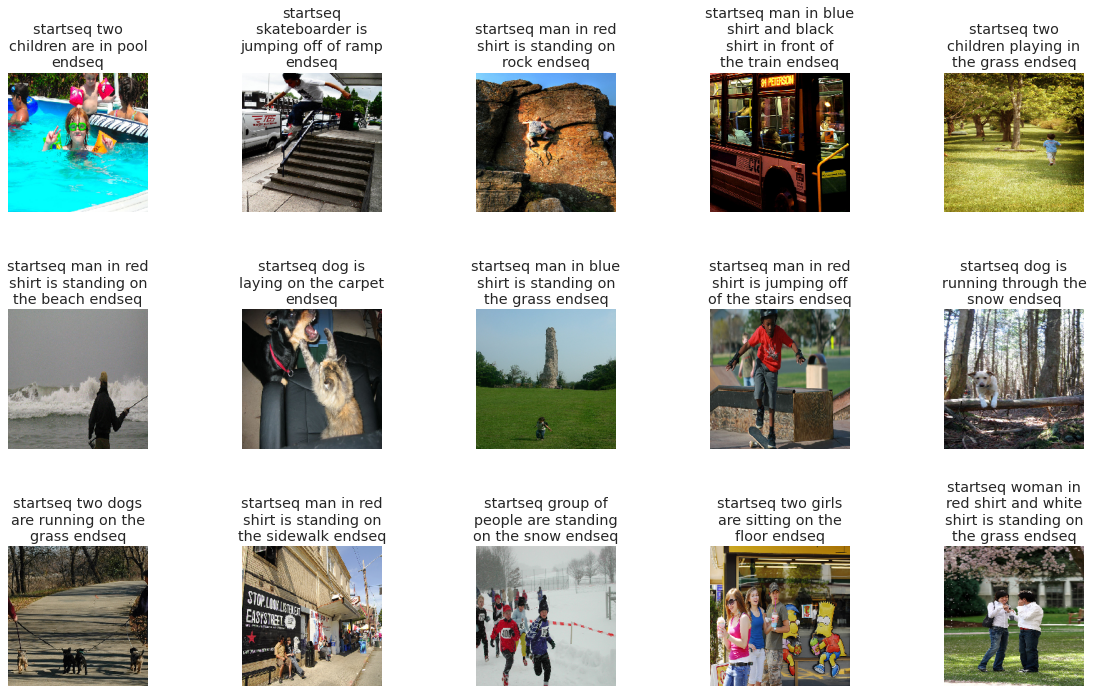

In [35]:
display_images(samples)